In [1]:
import sys
sys.path.insert(0, '/home/sos/CIC/system/dialogue_manager')
print(sys.executable)
import dataset
from dataset.cic import make_or_load_cic
from chart_parser.astar_parse import chart_parse
from chart_parser.AStarQ import AStarQ
from chart_parser.node import node
from chart_parser.logic import get_logical_form

from chart_parser.util import load_grammar
from chart_parser.util import load_grammar_intent_map
from chart_parser.util import get_correct_sentence
from state.state import INTENTS
from config import config

from manager.manager import manager

from model.QAModel import QAModel
from model.QLearn import QLearn
from model.PQLearn import PQLearn
from model.SQAModel import SQAModel

import chart_parser
import os
import ast
import json
import pandas as pd
from magis.vocab import Vocabulary
import pickle
import numpy as np
import time
import math

import matplotlib.pyplot as plt

/usr/bin/python3


In [2]:
# os.environ['SIMULATOR'] = 'MODEL'
os.environ['DEVICE'] = 'cpu'
cic = make_or_load_cic()

In [3]:
(g, t, n, fs) = load_grammar(cic._color_vocab, os.getenv('CFG'))
g = pickle.load(open(os.path.dirname(dataset.__file__)  + '/pcfg_5.pkl', 'rb'))
(irmap, rimap) = load_grammar_intent_map(os.getenv('INTENT_MAP'))

In [5]:
num_actions = len(INTENTS)
models = [QAModel(num_actions), QAModel(num_actions)]
distributions = []
response_forms = []
for i in range(13000):
    models[0] = SQAModel(num_actions, cic=cic, ix=i)
    item = cic.get_index_item(i)
    
    colors = item['rgb_colors']
    clr_trans = item['x_colors']

    shuffled_colors = [tup for tup in zip(clr_trans, colors)]
    
    clr_pair = {'S':clr_trans, 'L': [shuffled_colors[i][0] for i in range(len(shuffled_colors))], \
                'S_RGB': colors, 'L_RGB' : [shuffled_colors[i][1] for i in range(len(shuffled_colors))]}
    
    dman = manager(clr_pair, *models, (g, t, n, fs), \
            (irmap, rimap), cic=cic, batch_dict=item)
    
    u , lf, done = dman.get_next_move()
    distributions.append(dman._state_rep._cur_state.distribution)

/home/sos/Dialogue_Research/color_in_context/system/dialogue_manager/manager/manager.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._colors[turn] = [torch.tensor(x).view(1, -1) for x in colors[turn]]


In [31]:
prob_buckets = dict()

buckets = np.zeros((20,))
for i, dist in enumerate(distributions):
    max_prob = np.max(dist)
    bucket_val = int(max_prob * 100) - (int(max_prob*100) % 5)
#     print(max_prob)
    item = cic[i]
    rix = item['row_index']
    interaction = json.loads(cic._df.iloc[rix]['full_text'])
    if len(interaction) == 1:
        buckets[int(bucket_val/5)] += 1
        
for i in range(len(buckets)):
    print('Prob >=%d bucket Count: %d, Percentage: %.2f' % (i*5, buckets[i], buckets[i] * 100/total))

Prob >=0 bucket Count: 0, Percentage: 0.00
Prob >=5 bucket Count: 0, Percentage: 0.00
Prob >=10 bucket Count: 0, Percentage: 0.00
Prob >=15 bucket Count: 0, Percentage: 0.00
Prob >=20 bucket Count: 0, Percentage: 0.00
Prob >=25 bucket Count: 0, Percentage: 0.00
Prob >=30 bucket Count: 536, Percentage: 4.48
Prob >=35 bucket Count: 7, Percentage: 0.06
Prob >=40 bucket Count: 16, Percentage: 0.13
Prob >=45 bucket Count: 215, Percentage: 1.80
Prob >=50 bucket Count: 122, Percentage: 1.02
Prob >=55 bucket Count: 119, Percentage: 1.00
Prob >=60 bucket Count: 116, Percentage: 0.97
Prob >=65 bucket Count: 152, Percentage: 1.27
Prob >=70 bucket Count: 322, Percentage: 2.69
Prob >=75 bucket Count: 565, Percentage: 4.73
Prob >=80 bucket Count: 779, Percentage: 6.52
Prob >=85 bucket Count: 896, Percentage: 7.50
Prob >=90 bucket Count: 1188, Percentage: 9.94
Prob >=95 bucket Count: 6919, Percentage: 57.89


In [ ]:
# parse_mistakes = pickle.load(open(os.path.dirname(dataset.__file__) + '/parse_mistakes.pkl', 'rb'))
# # def get_
# parse_mistake = list(filter(lambda x : x <= 5000, parse_mistakes))
prob_bucket = dict()
mis_classified = 0
misclassified_bucket = dict()
# print('Total Number:', len(distributions))
for i, dist in enumerate(distributions):
    prob = max(dist)
    bucket = math.floor(prob * 10)
    prob_bucket.setdefault(bucket, [])
#     prob_bucket[bucket] += 1
    prob_bucket[bucket].append(i)
#     if np.argmax(dist) != 0:
#         mis_classified += 1
#         misclassified_bucket.setdefault(bucket, [])
#         misclassified_bucket[bucket].append(i)
# print('MisClassified:', mis_classified)
print('Number of items in probability buckets')
for k in prob_bucket.keys():
    print(k, len(prob_bucket[k]))
# print('Number of items in misclassified buckets')
# for k in misclassified_bucket.keys():
#     print(k, len(misclassified_bucket[k]))

In [ ]:
prob_bucket = dict()
mis_classified = 0
misclassified_bucket = dict()
print('Total Number:', len(distributions))
for i, dist in enumerate(distributions):
    if i > 5000:
        break
    prob = max(dist)
    bucket = math.floor(prob * 10)
    prob_bucket.setdefault(bucket, [])
    prob_bucket[bucket].append(i)
    if np.argmax(dist) != 0 and i not in parse_mistakes:
        mis_classified += 1
        misclassified_bucket.setdefault(bucket, [])
        misclassified_bucket[bucket].append(i)
print('MisClassified:', mis_classified)
print('Number of items in probability buckets')
for k in prob_bucket.keys():
    print(k, len(prob_bucket[k]))
print('Number of items in misclassified buckets')
for k in misclassified_bucket.keys():
    print(k, len(misclassified_bucket[k]))

In [4]:
def initialize_state(start_k, first_variable, state_tracker, grammar):
    start_state, prob = grammar[first_variable][0]
#     start_state = (start_state, (start_k, 0), first_variable, start_k, -1, 0)
    
    start_node = node(first_variable, [], None, start=start_k, end=-1)
    
    start_state = (start_state, (start_k, 0), first_variable, start_k, ('<P>',))
    start_cost = (-start_k, -prob) #-prob
    
    state_tracker[start_k][(start_state, start_cost)] = start_node
    
    queue = AStarQ()
    queue.add_node(start_state, start_node, start_cost, 0)
    
    max_node = (start_node, (-start_k, -prob))
    
    return queue, state_tracker, max_node

In [5]:
def make_copy(parse_tree):
    node_copy = node(parse_tree.var, [], parse_tree.parent, start=parse_tree.start, end=parse_tree.end)
    for child in parse_tree.children:
        node_copy.children.append(make_copy(child))
    return node_copy

In [6]:
def check_if_in_first(variable, nonterminals, terminals, first_set, k, string):
    if k < len(string) and (variable in nonterminals) and \
        (string[k] not in first_set[variable]):
        return True
    return False

In [7]:
def score_grammar(count_grammar, cur_node, nonterminals):
#     print('$$$$$$$$$$')
#     cur_node.print_tree()
#     print('$$$$$$$$$$')
    count_grammar[cur_node.var]['count_'] += 1
    rule = ' '.join([child.var for child in cur_node.children])
    count_grammar[cur_node.var][rule] += 1
    for child in cur_node.children:
        if child.var in nonterminals:
            score_grammar(count_grammar, child, nonterminals)

In [8]:
def get_num_parses(parse_trees):
    res = 0
    for tree in parse_trees:
        if tree:
            res += 1
    return res

In [9]:
def remove_terminals(tree):
    if len(tree) == 1:
        return tuple()
    node_name = tree[0]
    new_tree = [node_name]
    for i in range(1, len(tree)):
        modified = remove_terminals(tree[i])
        if modified == tuple():
            continue
        new_tree.append(modified)
    return tuple(new_tree)

In [10]:
def check_if_node(tree, node_name='CLR'):
    ans = False
    if tree[0] == node_name:
        return True
    for i in range(1, len(tree)):
        ans = ans or check_if_node(tree[i], node_name)
    return ans

In [11]:
def remove_node(tree, node_name='CP'):
    if tree[0] == node_name:
        return tuple((tree[0],))
    new_tree = [tree[0]]
    for i in range(1, len(tree)):
        modified = remove_node(tree[i], node_name)
        if modified == tuple():
            continue
        new_tree.append(modified)
    return tuple(new_tree)

In [34]:
def preprocess(sentence, vocabulary):
    start = 0
    result = []
    while start < len(sentence):
        max_length = 0
        term_ix = -1
        for i in range(0, 3):
            cur_term = ' '.join(sentence[start:start + i + 1])
            try:
                term_ix = vocabulary[cur_term]
                max_length = i + 1
            except Exception as e:
                pass
        if max_length == 0:
            result.append(sentence[start])
            start += 1
        else:
            result.append(str(term_ix))
            start += max_length
    return result

os.environ['DEVICE'] = 'cpu'
count_grammar = dict()
for key in g:
    count_grammar[key] = dict()
    count_grammar[key]['count_'] = 0
    for transition_rule in g[key]:
        count_grammar[key][transition_rule[0]] = 0

# irmap, rimap = load_grammar_intent_map(dir_name + '/gram_intent_map')
symbol_list = ['.', ',', '?', '/', '\\', '?', '-', ';', '!']

not_parsed = []
not_parsed_count = 0
treecount_to_text = dict()
treecount_to_sentcount = dict()

csv_file = cic._df
max_samples = len(cic)
count = 0
item = csv_file.iloc[0]

total_time = dict()
parse_mistakes = set()

response_analysis = dict()
same_phrase = dict()
response_miss = dict()

total_count_gt3 = 0
total_count_nocp = 0
total_count_miscp_listener = 0
total_count_miscp_speaker = 0
total_count_noturns_speaker = 0
total_count_noturns_listener = 0

# cic.set_indexes('dev')

num_actions = len(INTENTS)
models = [QAModel(num_actions), QAModel(num_actions)]
misclassify = [0, 0]

distribution_response_map = dict()

for i, item in enumerate(cic):
    rix = item['row_index']
    cur_condition = csv_file.iloc[rix].loc['condition']
    full_text = csv_file.iloc[rix].loc['full_text']
    interaction = json.loads(full_text)
    if len(interaction) <= 2:
        continue
    print('----------------------')
    print('csv_index:', rix)
    print('Dialogue Moves:', interaction)
    print('**********************')
    
    roles = ['speaker', 'listener']
    
    parses = []
    color_phrases = []
    
    not_valid = False
    move_index = 0
    
    for role in roles:
#         if move_index > 0 and move_index < len(interaction) and interaction[move_index]['role'] != role:
#             not_valid = True
#             break 
            
        while move_index < len(interaction) and \
            interaction[move_index]['role'] != role:
            move_index += 1
    
        if move_index == len(interaction):
            not_valid = True
            total_count_noturns_speaker += (role == 'speaker')
            total_count_noturns_listener += (role == 'listener')
            break
        
        move = interaction[move_index]
        utterance = move['text'].lower()
        for s in symbol_list:
            utterance = (' ' + s + ' ').join(utterance.split(s)).strip()
        parse_input = utterance.split()

        parse_input = get_correct_sentence(parse_input, t, cic.spellcheck_map)
        parse_input = preprocess(parse_input, cic._color_vocab)
        
        cur_cp = list(filter(lambda x : x.isdigit(), parse_input))
        color_phrases.append(cur_cp)
        
        parse_trees = chart_parse(parse_input, g, t, n, fs, '<P>')
        
        if len(parse_trees) > 1 or None in parse_trees:
            parse_mistakes.add(i)
            if role == 'listener':
                total_count_miscp_listener += 1
            else:
                total_count_miscp_speaker += 1
            total_count_nocp += (len(cur_cp) == 0 and role == 'listener')
            
            not_valid = True
            
        parses.append(parse_trees[0])
        move_index += 1
    
    if not_valid:
        continue
    
    total_count_gt3 += 1
    logic_form = get_logical_form(cic._color_vocab, rimap, irmap, parses[0], 'G')
    
    def get_name_args(form_const):
        split_form = form_const.split('(')
        if 'COMPARE_REF' in form_const:
            return str(tuple([split_form[0].strip(), split_form[1].split(',')[1].strip()]))
        return split_form[0].strip()
    
    logic_names = list([get_name_args(name) for name in logic_form[0].split('AND')])
    speaker_strategy = tuple(map(lambda x : 'IDENTIFY' if x == 'IDENTIFY_SET' else x, \
                    filter(lambda x : x != 'ASK_CLARIFICATION', logic_names)))
    
#     distribution_response_map.setdefault(tuple(distributions[i]), [])
#     distribution_response_map[tuple(distributions[i])].append(listener_strategy)
#     print('*************************')
#     print('Logic Names:', logic_names)
#     print('Listener Strategy:', listener_strategy)
# #     print(list(filter(lambda x : x != 'ASK_CLARIFICATION', logic_names)))
#     print(color_phrases)
#     print('*************************')
    
    logic_form = get_logical_form(cic._color_vocab, rimap, irmap, parses[1], 'G')
    logic_names = list([get_name_args(name) for name in logic_form[0].split('AND')])
    listener_strategy = tuple(map(lambda x : 'IDENTIFY' if x == 'IDENTIFY_SET' else x, \
                    filter(lambda x : x != 'ASK_CLARIFICATION', logic_names)))
    
    response_analysis.setdefault(speaker_strategy, dict())
    response_analysis[speaker_strategy].setdefault(listener_strategy, dict())
    response_analysis[speaker_strategy].setdefault('_count', 0)
    
    response_analysis[speaker_strategy]['_count'] += 1
    response_analysis[speaker_strategy][listener_strategy].setdefault('_count', 0)
    response_analysis[speaker_strategy][listener_strategy]['_count'] += 1
    
#     print('Color Terms Used:', color_phrases)
    
#     if len(set(color_phrases[0]) & set(color_phrases[1])) >= 1:
#         same_phrase.setdefault(listener_strategy, dict())
#         same_phrase[listener_strategy].setdefault(speaker_strategy, [])
#         same_phrase[listener_strategy][speaker_strategy].append(color_phrases)
    
#     response_miss.setdefault(listener_strategy, dict())
#     response_miss[listener_strategy].setdefault('count', 0)
#     response_miss[listener_strategy].setdefault(speaker_strategy, [0, 0])
#     print(move)
#     response_miss[listener_strategy][speaker_strategy][0] += len(move['text'].split())
#     response_miss[listener_strategy][speaker_strategy][1] += 1
#     response_miss[listener_strategy]['count'] += 1


#     item = cic.get_index_item(i)
    
#     colors = item['rgb_colors']
#     clr_trans = item['x_colors']

#     shuffled_colors = [tup for tup in zip(clr_trans, colors)]
    
#     clr_pair = {'S':clr_trans, 'L': [shuffled_colors[i][0] for i in range(len(shuffled_colors))], \
#                 'S_RGB': colors, 'L_RGB' : [shuffled_colors[i][1] for i in range(len(shuffled_colors))]}
    
#     dman = manager(clr_pair, *models, (g, t, n, fs), \
#             (irmap, rimap), cic=cic, batch_dict=item)
    
#     u , lf, done = dman.get_next_move({'name' : 'S', 'text' : move['text']})
    
#     state_rep = dman._state_rep._cur_state
    
#     while state_rep and state_rep.speaker != 'L':
#         state_rep = state_rep.prev
    
#     response_miss.setdefault(listener_strategy, [0, 0])
    
#     dist = state_rep.distribution
#     if np.argmax(dist) == 0:
#         response_miss[listener_strategy][0] += 1
#     else:
#         response_miss[listener_strategy][1] += 1
#     print(move, role)
################################################################################
#Above this line is strategy mining code
################################################################################
#     move = interaction[move_index]
#     utterance = move['text'].lower()
#     for s in symbol_list:
#         utterance = (' ' + s + ' ').join(utterance.split(s)).strip()
#     parse_input = utterance.split()
    
#     parse_input = get_correct_sentence(parse_input, t, cic.spellcheck_map)
#     parse_input = preprocess(parse_input, cic._color_vocab)
    
#     parse_trees = chart_parse(parse_input, g, t, n, fs, '<P>')
    
#     if len(parse_trees) > 1 or None in parse_trees:
#         parse_mistakes.append(i)
#         continue
    
#     str_tree = parse_trees[0].to_str()
#     occurrence_count = str_tree.count('CLR')
#     str_tree = remove_node(remove_terminals(str_tree))
#     logic_form = get_logical_form(cic._color_vocab, rimap, irmap, parse_trees[0], 'G')
#     str_tree = tuple([name.split('(')[0] for name in logic_form[0].split('AND')])
    
#     while move_index < len(interaction) and \
#         interaction[move_index]['role'] != 'speaker':
#         move_index += 1
    
#     if move_index == len(interaction):
#         continue
        
#     move = interaction[move_index]
#     utterance = move['text'].lower()
#     for s in symbol_list:
#         utterance = (' ' + s + ' ').join(utterance.split(s)).strip()
#     parse_input = utterance.split()
    
#     parse_input = get_correct_sentence(parse_input, t, cic.spellcheck_map)
#     parse_input = preprocess(parse_input, cic._color_vocab)
    
#     parse_trees = chart_parse(parse_input, g, t, n, fs, '<P>')
#     if len(parse_trees) > 1 or None in parse_trees:
#         continue
        
#     logic_form = get_logical_form(cic._color_vocab, rimap, irmap, parse_trees[0], 'G')
#     str_response_tree = tuple([name.split('(')[0] for name in logic_form[0].split('AND')])
    
#     response_analysis.setdefault(str_tree, dict())
#     response_analysis[str_tree].setdefault(str_response_tree, dict())
#     response_analysis[str_tree].setdefault('_count', 0)
    
#     response_analysis[str_tree]['_count'] += 1
#     response_analysis[str_tree][str_response_tree].setdefault('_count', 0)
#     response_analysis[str_tree][str_response_tree]['_count'] += 1
#     response_analysis[occurrence_count].add(str_response_tree)
#     for move in interaction:
#         cur_role = move['role']
#         if cur_role != 'speaker':
#             continue
#         utterance = move['text'].lower()
#         for s in symbol_list:
#             utterance = (' ' + s + ' ').join(utterance.split(s)).strip()
#         parse_input = utterance.split()
        
#         print('Index in CSV File:', rix, 'About to Parse:', parse_input)
#         parse_input = get_correct_sentence(parse_input, t, cic.spellcheck_map)
#         parse_input = preprocess(parse_input, cic._color_vocab)
        
#         start_time = time.time()
#         parse_trees = chart_parse(parse_input, g, t, n, fs, '<P>')
#         if len(parse_trees) > 1:
#             parse_mistakes.append(i)
#         if cur_role == 'speaker':
#             break
#         difference = (time.time() - start_time)
#         if len(parse_trees) > 1:
#             not_parsed.append(utterance)
#             not_parsed_count += 1
#             tree_count = get_num_parses(parse_trees)
            
#             total_time.setdefault(tree_count, 0)
#             total_time[tree_count] += difference
            
#             treecount_to_text.setdefault(tree_count, [])
#             treecount_to_text[tree_count].append(utterance)
#             treecount_to_sentcount.setdefault(tree_count, 0)
#             treecount_to_sentcount[tree_count] += 1
#         else:
#             total_time.setdefault('full', 0)
#             total_time['full'] += difference
        
#         print(cur_role + ':', utterance, ' | Count:', count, ' | iteration_count:', (i+1))
#         count += 1
#         if count % 100 == 0:
#             print('Percentage Till Now:', 100 * not_parsed_count/count)
#     print('----------------------')
#     break
    
# print('Not Parsed Sentences:')
# for sentence in not_parsed:
#     print('Sentence:', sentence)
# print('Not Parsed Count:', not_parsed_count)
# print('Percentage:', 100 * not_parsed_count/count)
# print('Average Time Per Utterance:', total_time/count)
# for k in treecount_to_sentcount:
#     ptree_count = treecount_to_sentcount[k]
#     print('Percentage for count of ', str(k) + ':', 100 * ptree_count/count)

----------------------
csv_index: 102
Dialogue Moves: [{'text': 'the very dull red', 'subject': {'worker_id': 963.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459877321709.0}, {'text': 'lighter or darker', 'subject': {'worker_id': 962.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1459877334773.0}, {'text': 'lighter', 'subject': {'worker_id': 963.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459877346747.0}]
**********************
----------------------
csv_index: 278
Dialogue Moves: [{'text': 'Blue', 'subject': {'worker_id': 385.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459880231866.0}, {'text': 'No idea hehe', 'subject': {'worker_id': 385.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459880237376.0}, {'text': 'blue??', 'subject': {'worker_id': 156.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human

----------------------
csv_index: 1211
Dialogue Moves: [{'text': 'pea soup', 'subject': {'worker_id': 118.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459884954889.0}, {'text': 'brighter tone or darker?', 'subject': {'worker_id': 106.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1459884969258.0}, {'text': 'closer to the sun', 'subject': {'worker_id': 118.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459884969501.0}, {'text': 'brighter', 'subject': {'worker_id': 118.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459884972162.0}]
**********************
----------------------
csv_index: 1216
Dialogue Moves: [{'text': 'muter closer to the sky', 'subject': {'worker_id': 118.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459885045264.0}, {'text': 'muted', 'subject': {'worker_id': 118.0, 'role': 'speaker'}, 'role': 'speaker',

----------------------
csv_index: 1690
Dialogue Moves: [{'text': 'purple blue teal', 'subject': {'worker_id': 57.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1459887547491.0}, {'text': 'last one', 'subject': {'worker_id': 133.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459887551498.0}, {'text': "They're not in the same order on my screen remember?", 'subject': {'worker_id': 57.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1459887563381.0}, {'text': 'The last one you wrote.', 'subject': {'worker_id': 133.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459887573322.0}]
**********************
----------------------
csv_index: 1711
Dialogue Moves: [{'text': 'Second brightest purple', 'subject': {'worker_id': 95.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459886934778.0}, {'text': 'Hello?', 'subject': {'worker_id': 95.

----------------------
csv_index: 2289
Dialogue Moves: [{'text': 'lime green', 'subject': {'worker_id': 113.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459889735987.0}, {'text': 'dark or light', 'subject': {'worker_id': 66.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1459889750580.0}, {'text': 'light and bright', 'subject': {'worker_id': 113.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459889764073.0}]
**********************
----------------------
csv_index: 2298
Dialogue Moves: [{'text': 'medium green- forest', 'subject': {'worker_id': 113.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459889934759.0}, {'text': 'dull or bright', 'subject': {'worker_id': 66.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1459889956572.0}, {'text': 'dull but not the olive color', 'subject': {'worker_id': 113.0, 'role': 'speaker'}, 'r

----------------------
csv_index: 2734
Dialogue Moves: [{'text': 'orange', 'subject': {'worker_id': 165.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459891934189.0}, {'text': "i'm gonna be color blind after this is over", 'subject': {'worker_id': nan, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1459891940153.0}, {'text': 'haha maybe', 'subject': {'worker_id': 165.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459891948195.0}, {'text': 'torq, gray, yellow', 'subject': {'worker_id': nan, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1459891966115.0}, {'text': 'yellow... i see orange though..', 'subject': {'worker_id': 165.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459891988496.0}, {'text': '*turq', 'subject': {'worker_id': nan, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1459891989317.0

----------------------
csv_index: 3067
Dialogue Moves: [{'text': 'haha why thank you =D uhm, not the reddish purple or the brighter purple', 'subject': {'worker_id': 34.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459893009682.0}, {'text': 'so i guess the mauveish one?', 'subject': {'worker_id': 34.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459893017140.0}, {'text': 'Alright my friend, see you soon! c:', 'subject': {'worker_id': 80.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1459893043870.0}]
**********************
----------------------
csv_index: 3071
Dialogue Moves: [{'text': 'Red and blue make this color.', 'subject': {'worker_id': 137.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459892304455.0}, {'text': 'Where are you from?', 'subject': {'worker_id': 32.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 14598

----------------------
csv_index: 3381
Dialogue Moves: [{'text': 'deep purple not lighter', 'subject': {'worker_id': 108.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459893250172.0}, {'text': "it's a darker purple", 'subject': {'worker_id': 108.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459893263684.0}, {'text': 'is it the brightest color of the 3 with blue tones?', 'subject': {'worker_id': 1.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1459893282669.0}, {'text': "the darkest but it's more purple to me not the blue", 'subject': {'worker_id': 108.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459893297509.0}]
**********************
----------------------
csv_index: 3388
Dialogue Moves: [{'text': 'medium green but not as bright as the other two', 'subject': {'worker_id': 108.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestam

----------------------
csv_index: 3688
Dialogue Moves: [{'text': 'reddish/gray', 'subject': {'worker_id': 173.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459895073990.0}, {'text': 'beige', 'subject': {'worker_id': 173.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459895081681.0}, {'text': 'er', 'subject': {'worker_id': 173.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459895084430.0}, {'text': 'red/beige/gray color', 'subject': {'worker_id': 173.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459895088242.0}, {'text': 'has brown in it too', 'subject': {'worker_id': 173.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459895092830.0}]
**********************
----------------------
csv_index: 3703
Dialogue Moves: [{'text': 'reddish pink, but brighter than the other red/gray', 'subject': {'worker_id': 173.0, 'role': 'speaker'

----------------------
csv_index: 3994
Dialogue Moves: [{'text': 'The green', 'subject': {'worker_id': 5.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459896056907.0}, {'text': 'more or less blue?', 'subject': {'worker_id': 183.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1459896071055.0}, {'text': 'less blue', 'subject': {'worker_id': 5.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459896077277.0}]
**********************
----------------------
csv_index: 4001
Dialogue Moves: [{'text': 'least gray', 'subject': {'worker_id': 5.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459896202795.0}, {'text': 'greenish or bluish? this one is tough', 'subject': {'worker_id': 183.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1459896232426.0}, {'text': 'more purple i think', 'subject': {'worker_id': 5.0, 'role': 'speaker'}, 'role':

----------------------
csv_index: 4671
Dialogue Moves: [{'text': 'less green', 'subject': {'worker_id': 76.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459898824343.0}, {'text': 'blue or blue gray', 'subject': {'worker_id': 141.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1459898844303.0}, {'text': 'more grey', 'subject': {'worker_id': 76.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459898851341.0}]
**********************
----------------------
csv_index: 4675
Dialogue Moves: [{'text': 'mix of pink block and purple block', 'subject': {'worker_id': 76.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1459898893542.0}, {'text': 'light pink or more purpleish', 'subject': {'worker_id': 141.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1459898925750.0}, {'text': 'light pink', 'subject': {'worker_id': 76.0, 'role': 'speaker'

----------------------
csv_index: 5019
Dialogue Moves: [{'text': 'grey', 'subject': {'worker_id': 217.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476460232125.0}, {'text': 'the more or less blue one', 'subject': {'worker_id': 685.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476460239286.0}, {'text': 'not borwn', 'subject': {'worker_id': 217.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476460240121.0}, {'text': 'blue', 'subject': {'worker_id': 217.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476460244620.0}]
**********************
----------------------
csv_index: 5024
Dialogue Moves: [{'text': 'dark green', 'subject': {'worker_id': 217.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476460302035.0}, {'text': 'not bright', 'subject': {'worker_id': 217.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human'

----------------------
csv_index: 5322
Dialogue Moves: [{'text': 'The closest to mint green -- not the primary green, not the yellow green', 'subject': {'worker_id': 590.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476465873841.0}, {'text': 'the more forest fir tree shade?', 'subject': {'worker_id': 719.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476465890701.0}, {'text': 'ys', 'subject': {'worker_id': 590.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476465893088.0}]
**********************
----------------------
csv_index: 5324
Dialogue Moves: [{'text': 'more primary purple', 'subject': {'worker_id': 590.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476465912315.0}, {'text': 'more pink?', 'subject': {'worker_id': 719.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476465920456.0}, {'text': 'Not the grayish purple

----------------------
csv_index: 5553
Dialogue Moves: [{'text': 'same - not magenta, muted pink', 'subject': {'worker_id': 721.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476466521297.0}, {'text': 'darker pink', 'subject': {'worker_id': 721.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476466546882.0}, {'text': 'the more fuschia? or the more brick colored', 'subject': {'worker_id': 719.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476466547871.0}, {'text': 'brick', 'subject': {'worker_id': 721.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476466551569.0}]
**********************
----------------------
csv_index: 5569
Dialogue Moves: [{'text': 'the real blue, not indigo', 'subject': {'worker_id': 721.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476466736346.0}, {'text': 'the lighter blue', 'subject': {'worker_id': 

----------------------
csv_index: 6193
Dialogue Moves: [{'text': '2nd brightest blue', 'subject': {'worker_id': 703.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476468744470.0}, {'text': 'dark or bright?', 'subject': {'worker_id': 672.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476468756737.0}, {'text': 'bright', 'subject': {'worker_id': 703.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476468761845.0}]
**********************
----------------------
csv_index: 6233
Dialogue Moves: [{'text': 'pale purple', 'subject': {'worker_id': 703.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476469365972.0}, {'text': 'that looks greyish', 'subject': {'worker_id': 703.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476469368258.0}, {'text': 'a bit', 'subject': {'worker_id': 703.0, 'role': 'speaker'}, 'role': 'speaker', 'person_typ

----------------------
csv_index: 6767
Dialogue Moves: [{'text': 'sage green', 'subject': {'worker_id': 663.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476469710459.0}, {'text': 'medium', 'subject': {'worker_id': 663.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476469714581.0}, {'text': 'olive', 'subject': {'worker_id': 663.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476469715880.0}]
**********************
----------------------
csv_index: 6984
Dialogue Moves: [{'text': 'gray, not grayish blue', 'subject': {'worker_id': 254.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476470175751.0}, {'text': "is it the one that's more brown?", 'subject': {'worker_id': 235.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476470190876.0}, {'text': 'the duller one, looks more silver almost', 'subject': {'worker_id': 254.0, 'role': 

----------------------
csv_index: 7342
Dialogue Moves: [{'text': 'orange', 'subject': {'worker_id': 675.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476468488668.0}, {'text': 'umm', 'subject': {'worker_id': 73.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476468498432.0}, {'text': 'Yellow orange', 'subject': {'worker_id': 675.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476468499541.0}]
**********************
----------------------
csv_index: 7374
Dialogue Moves: [{'text': 'not light blue and not dark blue turqoise*', 'subject': {'worker_id': 675.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476468854592.0}, {'text': 'Its the in betweener', 'subject': {'worker_id': 675.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476468862622.0}, {'text': 'that was fun. i hope you have a wonderful day. enjoy your weekend.', 'subje

----------------------
csv_index: 7604
Dialogue Moves: [{'text': 'lime green, then deeper of the two greens', 'subject': {'worker_id': 669.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476471720032.0}, {'text': 'green with yellowish hue?', 'subject': {'worker_id': 487.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476471742778.0}, {'text': 'no i would say the other one', 'subject': {'worker_id': 669.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476471760397.0}]
**********************
----------------------
csv_index: 7630
Dialogue Moves: [{'text': 'dull and muddy', 'subject': {'worker_id': 744.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476471326430.0}, {'text': 'more brownish or dark?', 'subject': {'worker_id': 384.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476471359549.0}, {'text': 'are we allowed to say colo

----------------------
csv_index: 8182
Dialogue Moves: [{'text': 'olive green', 'subject': {'worker_id': 236.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476472363424.0}, {'text': 'not neon', 'subject': {'worker_id': 236.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476472373455.0}, {'text': 'not orange green', 'subject': {'worker_id': 236.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476472377010.0}]
**********************
----------------------
csv_index: 8188
Dialogue Moves: [{'text': 'orange', 'subject': {'worker_id': 236.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476472473672.0}, {'text': 'ish', 'subject': {'worker_id': 236.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476472475576.0}, {'text': 'sorry!  That was a fail on my part', 'subject': {'worker_id': 670.0, 'role': 'listener'}, 'role': 'listener', 'perso

----------------------
csv_index: 8574
Dialogue Moves: [{'text': 'pastel green', 'subject': {'worker_id': 753.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476471792205.0}, {'text': 'is it slightly brownish-green as opposed to bright green?', 'subject': {'worker_id': 293.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476471825373.0}, {'text': 'brownish green', 'subject': {'worker_id': 753.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476471829623.0}]
**********************
----------------------
csv_index: 8621
Dialogue Moves: [{'text': 'not grey, not lighter muted grey blue', 'subject': {'worker_id': 753.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476472642208.0}, {'text': "so it's the blue with the least grey or green in it?", 'subject': {'worker_id': 293.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 147647268974

----------------------
csv_index: 9436
Dialogue Moves: [{'text': 'they greyish looking one', 'subject': {'worker_id': 762.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476474292279.0}, {'text': 'I see dark green, brighter green, and a brownish color', 'subject': {'worker_id': 724.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476474320752.0}, {'text': 'brown one you think?', 'subject': {'worker_id': 724.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476474323790.0}, {'text': 'yes', 'subject': {'worker_id': 762.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476474326004.0}]
**********************
----------------------
csv_index: 9450
Dialogue Moves: [{'text': 'teal', 'subject': {'worker_id': 762.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476474585408.0}, {'text': 'the lighter green', 'subject': {'worker_id': 762.0,

----------------------
csv_index: 9868
Dialogue Moves: [{'text': 'green', 'subject': {'worker_id': 286.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476474847513.0}, {'text': 'light or dark', 'subject': {'worker_id': 743.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476474854795.0}, {'text': 'dark', 'subject': {'worker_id': 286.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476474859178.0}]
**********************
----------------------
csv_index: 9882
Dialogue Moves: [{'text': 'green', 'subject': {'worker_id': 286.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476475054529.0}, {'text': 'turqouise?', 'subject': {'worker_id': 743.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476475070731.0}, {'text': 'no', 'subject': {'worker_id': 286.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 147647

----------------------
csv_index: 10373
Dialogue Moves: [{'text': 'most purple', 'subject': {'worker_id': nan, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476475650240.0}, {'text': 'not barney purple?', 'subject': {'worker_id': 549.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476475655951.0}, {'text': 'more like nick jr purple?', 'subject': {'worker_id': 549.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476475661191.0}, {'text': 'dont know', 'subject': {'worker_id': nan, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476475666326.0}, {'text': 'darkest', 'subject': {'worker_id': nan, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476475670553.0}]
**********************
----------------------
csv_index: 10374
Dialogue Moves: [{'text': 'blue', 'subject': {'worker_id': nan, 'role': 'speaker'}, 'role': 'speaker', 'person_type':

----------------------
csv_index: 10880
Dialogue Moves: [{'text': 'the one that is least blue', 'subject': {'worker_id': 667.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476475861840.0}, {'text': 'And not purple?', 'subject': {'worker_id': 748.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476475872384.0}, {'text': 'not purple', 'subject': {'worker_id': 667.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476475883246.0}]
**********************
----------------------
csv_index: 10881
Dialogue Moves: [{'text': 'gray', 'subject': {'worker_id': 667.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476475893791.0}, {'text': 'what do you see', 'subject': {'worker_id': 667.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476475912790.0}, {'text': 'There is a purpleish gray and a bluish gray and a pure gray', 'subject': {'worker_id':

----------------------
csv_index: 11135
Dialogue Moves: [{'text': 'pink', 'subject': {'worker_id': 286.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476479227944.0}, {'text': 'pink', 'subject': {'worker_id': 286.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476479239991.0}, {'text': 'say some example colors like military green, parrot green', 'subject': {'worker_id': 778.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476479248818.0}]
**********************
----------------------
csv_index: 11136
Dialogue Moves: [{'text': 'I have no idea what parrot green is', 'subject': {'worker_id': 286.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476479265714.0}, {'text': 'true green', 'subject': {'worker_id': 286.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476479272832.0}, {'text': 'parrot is bird man', 'subject': {'worker_id': 

----------------------
csv_index: 11462
Dialogue Moves: [{'text': 'blue', 'subject': {'worker_id': 667.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476480446002.0}, {'text': 'bright', 'subject': {'worker_id': 667.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476480448674.0}, {'text': 'bluish violet', 'subject': {'worker_id': 667.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476480461162.0}]
**********************
----------------------
csv_index: 11790
Dialogue Moves: [{'text': 'camo green', 'subject': {'worker_id': 782.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476479446926.0}, {'text': 'not the brighter one', 'subject': {'worker_id': 782.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476479452696.0}, {'text': 's', 'subject': {'worker_id': 782.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'times

----------------------
csv_index: 12261
Dialogue Moves: [{'text': 'like a greenish brownish', 'subject': {'worker_id': 319.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476479332097.0}, {'text': 'with a hint of yellow', 'subject': {'worker_id': 319.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476479344621.0}, {'text': 'got it', 'subject': {'worker_id': 693.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476479348833.0}]
**********************
----------------------
csv_index: 12262
Dialogue Moves: [{'text': 'blue', 'subject': {'worker_id': 319.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476479357826.0}, {'text': 'blue and not purple/blue?', 'subject': {'worker_id': 693.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476479366359.0}, {'text': 'yep', 'subject': {'worker_id': 319.0, 'role': 'speaker'}, 'role': 'speaker

----------------------
csv_index: 12592
Dialogue Moves: [{'text': 'orange', 'subject': {'worker_id': 808.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476484602436.0}, {'text': 'what', 'subject': {'worker_id': 799.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476484607574.0}, {'text': 'yellow', 'subject': {'worker_id': 808.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476484611942.0}]
**********************
----------------------
csv_index: 12593
Dialogue Moves: [{'text': 'red', 'subject': {'worker_id': 808.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476484627338.0}, {'text': 'no', 'subject': {'worker_id': 799.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476484632422.0}, {'text': 'redish. like red sand', 'subject': {'worker_id': 808.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1

----------------------
csv_index: 12951
Dialogue Moves: [{'text': 'ugh. lighter green', 'subject': {'worker_id': 584.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476484982067.0}, {'text': 'the one that is more tan', 'subject': {'worker_id': nan, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476484995327.0}, {'text': 'or more gray', 'subject': {'worker_id': nan, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476485001903.0}, {'text': 'sounds good', 'subject': {'worker_id': 584.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476485004375.0}]
**********************
----------------------
csv_index: 12972
Dialogue Moves: [{'text': 'rouge?', 'subject': {'worker_id': 584.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476485345922.0}, {'text': 'hot pink or light', 'subject': {'worker_id': nan, 'role': 'listener'}, 'role': 'listene

----------------------
csv_index: 13709
Dialogue Moves: [{'text': 'darker purple..kind of bright', 'subject': {'worker_id': 524.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476487431348.0}, {'text': 'not the more grey one?', 'subject': {'worker_id': 821.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476487451946.0}, {'text': 'no, the brighter, sharper one', 'subject': {'worker_id': 524.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476487463964.0}]
**********************
----------------------
csv_index: 13710
Dialogue Moves: [{'text': 'the most green', 'subject': {'worker_id': 524.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476487475392.0}, {'text': 'dimmer?', 'subject': {'worker_id': 821.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476487486099.0}, {'text': 'not bluish', 'subject': {'worker_id': 524.0, 'role': 

----------------------
csv_index: 13980
Dialogue Moves: [{'text': 'crayola blue', 'subject': {'worker_id': 210.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476488398912.0}, {'text': 'that the brightest blue', 'subject': {'worker_id': 407.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476488414980.0}, {'text': 'yea', 'subject': {'worker_id': 210.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476488428051.0}]
**********************
----------------------
csv_index: 14142
Dialogue Moves: [{'text': 'teal or seafoam green', 'subject': {'worker_id': 345.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476487681142.0}, {'text': 'not the more brown one', 'subject': {'worker_id': 345.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476487700173.0}, {'text': 'okay', 'subject': {'worker_id': 800.0, 'role': 'listener'}, 'role': 'listen

----------------------
csv_index: 14451
Dialogue Moves: [{'text': 'purple', 'subject': {'worker_id': 819.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476488094050.0}, {'text': 'birhgt purple', 'subject': {'worker_id': 819.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476488119157.0}, {'text': 'lavender, darker lavender, fuscia', 'subject': {'worker_id': 843.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476488123146.0}, {'text': 'i dunno the difference', 'subject': {'worker_id': 819.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476488131010.0}, {'text': 'the brightest one', 'subject': {'worker_id': 819.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476488133128.0}, {'text': 'two looks like blue one looks like purple', 'subject': {'worker_id': 819.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'times

----------------------
csv_index: 14623
Dialogue Moves: [{'text': 'not sky blue', 'subject': {'worker_id': 266.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476488968409.0}, {'text': 'the light blue of the others', 'subject': {'worker_id': 266.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476488991123.0}, {'text': 'blue with white', 'subject': {'worker_id': 266.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476488999534.0}]
**********************
----------------------
csv_index: 14669
Dialogue Moves: [{'text': 'that was aqua, lol', 'subject': {'worker_id': 549.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476488602911.0}, {'text': 'ok sneezing is annoying', 'subject': {'worker_id': 784.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476488603727.0}, {'text': 'red pink', 'subject': {'worker_id': 549.0, 'role': 'speaker'

----------------------
csv_index: 14870
Dialogue Moves: [{'text': 'pink', 'subject': {'worker_id': 834.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476489573347.0}, {'text': 'hot pink?', 'subject': {'worker_id': 584.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476489579966.0}, {'text': 'yes', 'subject': {'worker_id': 834.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476489581952.0}]
**********************
----------------------
csv_index: 14873
Dialogue Moves: [{'text': 'purple', 'subject': {'worker_id': 834.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476489650036.0}, {'text': 'lighter purple?', 'subject': {'worker_id': 584.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476489671108.0}, {'text': 'no, darkr', 'subject': {'worker_id': 834.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp

----------------------
csv_index: 15177
Dialogue Moves: [{'text': 'green', 'subject': {'worker_id': 855.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476490222546.0}, {'text': 'thees red gray or yellow?', 'subject': {'worker_id': 418.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476490241914.0}, {'text': 'grey', 'subject': {'worker_id': 855.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476490249589.0}]
**********************
----------------------
csv_index: 15221
Dialogue Moves: [{'text': 'not pinkish', 'subject': {'worker_id': 85.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476490122086.0}, {'text': 'sorry', 'subject': {'worker_id': 85.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476490124848.0}, {'text': 'okay the darker of the two light greens.', 'subject': {'worker_id': 85.0, 'role': 'speaker'}, 'role': 'speak

----------------------
csv_index: 15581
Dialogue Moves: [{'text': 'olive green looking the darker onebut bright', 'subject': {'worker_id': 767.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476490567576.0}, {'text': 'like grass', 'subject': {'worker_id': 189.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476490578161.0}, {'text': 'i know makes no sense, yea i think so', 'subject': {'worker_id': 767.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476490595089.0}, {'text': 'not neon yellow or drab', 'subject': {'worker_id': 189.0, 'role': 'listener'}, 'role': 'listener', 'person_type': 'human', 'timestamp': 1476490600144.0}, {'text': 'right drab', 'subject': {'worker_id': 767.0, 'role': 'speaker'}, 'role': 'speaker', 'person_type': 'human', 'timestamp': 1476490608771.0}]
**********************
----------------------
csv_index: 15645
Dialogue Moves: [{'text': 'grey blue', 'subject': {'worke

In [16]:
conv_lengths = []
for key in response_miss:
    conv_lengths.append((response_miss[key]['count'], key))
conv_lengths.sort()

for total_count, key in conv_lengths[::-1]:
    print('Count: %d, Strategy: %s' % (total_count, key))
    for skey in response_miss[key]:
        if skey == 'count':
            continue
        avg_len = response_miss[key][skey][0]/response_miss[key][skey][1]
        print('\tCount: %d, Strategy: %s, Average Length: %f' % (response_miss[key][skey][1], skey, avg_len))
    print('----------------------------')

In [35]:
total_count = 0
sorted_strategies = []
for key in response_analysis.keys():
    sorted_strategies.append((response_analysis[key]['_count'], key))
    total_count += response_analysis[key]['_count']
sorted_strategies.sort()
# print('This is the total count of clarifications:', total_count)

# for i, (count, key) in enumerate(sorted_strategies[::-1]):
#     print(i+1, key, count, count/total_count)
#     print('Number of Distinct Response Strategies:', len(response_analysis[key]))
#     for rk, rv in response_analysis[key].items():
#         if rk == '_count':
#             continue
#         print('\t', rk, rv, rv['_count']/count)
#     print('**************************')
# total_count_gt3
# total_count_noturns
# total_count_nocp
# total_count_miscp_listener
valid_mistakes = (total_count_miscp_speaker + \
                    (total_count_miscp_listener - total_count_nocp)) - total_count_noturns_speaker
valid_total = total_count_gt3 - total_count_nocp - total_count_noturns_speaker - total_count_noturns_listener
print('Valid Total: %d Valid Mistakes: %d' % (valid_total, valid_mistakes))
len(sorted_strategies[::-1])
# response_analysis.keys()
for i, (count, key) in enumerate(sorted_strategies[::-1]):
    print(i+1, key, count, count/total_count)
    print('Number of Distinct Response Strategies:', len(response_analysis[key]) - 1)
    for rk, rv in response_analysis[key].items():
        if rk == '_count':
            continue
        print('\t', rk, rv, rv['_count']/count)
    print('**************************')
print('####################################')
for i, list_strat in enumerate(same_phrase):
    print('Listener Strat:', list_strat, 'Number of Returning Strats:', len(same_phrase[list_strat]))
    for spk_strat in same_phrase[list_strat]:
        print('\tSpeaker Strat:', spk_strat, 'Repeating Count:', len(same_phrase[list_strat][spk_strat]))
    print('**************************')
response_miss

Valid Total: 28 Valid Mistakes: 270
1 ('IDENTIFY',) 147 0.875
Number of Distinct Response Strategies: 20
	 ('IDENTIFY',) {'_count': 53} 0.36054421768707484
	 ("('COMPARE_REF', '[or]')", 'IDENTIFY', 'IDENTIFY') {'_count': 57} 0.3877551020408163
	 ("('COMPARE_REF', '[or]')", 'IDENTIFY', 'IDENTIFY_FROM_REF', 'IDENTIFY', 'IDENTIFY') {'_count': 1} 0.006802721088435374
	 ('DISTINGUISH', 'IDENTIFY') {'_count': 2} 0.013605442176870748
	 ("('COMPARE_REF', '[and]')", 'IDENTIFY', 'IDENTIFY') {'_count': 3} 0.02040816326530612
	 ('DISTINGUISH', 'IDENTIFY_FROM_REF', 'IDENTIFY', 'IDENTIFY') {'_count': 1} 0.006802721088435374
	 ("('COMPARE_REF', '[or]')", 'IDENTIFY', 'REJECTION', 'IDENTIFY') {'_count': 1} 0.006802721088435374
	 ('IDENTIFY_FROM_REF', 'IDENTIFY', 'DISTINGUISH', 'IDENTIFY') {'_count': 1} 0.006802721088435374
	 ("('COMPARE_REF', '[')", 'IDENTIFY', "('COMPARE_REF', '[')", 'IDENTIFY', 'IDENTIFY') {'_count': 7} 0.047619047619047616
	 ("('COMPARE_REF', '[')", 'IDENTIFY', "('COMPARE_REF', '[or

{}

In [ ]:
# new_grammar = pickle.load(open(os.path.dirname(dataset.__file__) + '/pcfg_4.pkl', 'rb'))
# new_grammar['<conj>']
# 0.05269866705513876 * 0.28794788273615635 * 0.9993485342019544 * (0.605**2) * (0.8462002412545235**2) * \
# 0.003808113397154493 * 0.29800244598450876 * 0.09816470090442693 


# 0.07323912885133659 * 0.504885993485342 * 0.05269866705513876 * 0.9993485342019544 * 0.8462002412545235 *\
# 0.003808113397154493 * 0.29800244598450876 * 0.8462002412545235 * 0.6053609148517736 * 0.09816470090442693

# sum(total_time.values())/15285
# total_time[1]
# treecount_to_sentcount
# for k in treecount_to_sentcount:
#     avg = total_time[k]/treecount_to_sentcount[k]
#     print(k, avg)

In [19]:
# mistake_set = set(parse_mistakes)
# pickle.dump(mistake_set, open(os.path.dirname(dataset.__file__) + '/parse_mistakes.pkl', 'wb'))
# pickle.dump(mistake_set, open(os.path.dirname(dataset.__file__) + '/test_parse_mistakes.pkl', 'wb'))
# len(pickle.load(open(os.path.dirname(dataset.__file__) + '/parse_mistakes.pkl', 'rb')))
# len(parse_mistakes)
# parse_mistakes

2469

In [ ]:
# for sent in not_parsed:
#     print(sent)
# print('Not Parsed Percentage:', 100 * not_parsed_count / count)
# count_grammar
new_grammar = pickle.load(open(os.path.dirname(dataset.__file__) + '/pcfg_5.pkl', 'rb'))
# for key in count_grammar:
#     total_count = count_grammar[key]['count_']
#     new_grammar.setdefault(key, [])
#     for rule_key in count_grammar[key]:
#         if rule_key == 'count_':
#             continue
#         new_grammar[key].append((rule_key, count_grammar[key][rule_key]/total_count))
# pickle.dump(new_grammar, open(os.path.dirname(dataset.__file__) + '/pcfg_5.pkl', 'wb'))
new_grammar
# new_grammar['<CLR>']
# 0.05269866705513876 * 0.28794788273615635 * 0.9993485342019544 * 1 * \
# 0.29800244598450876 * 0.60 * 0.8462002412545235 * 0.003808113397154493 * 0.60 * 0.8462002412545235 * 0.09816470090442693

In [ ]:
parse_mistakes = pickle.load(open(os.path.dirname(dataset.__file__) + '/parse_mistakes.pkl', 'rb'))
prob_bucket = dict()
mis_classified = 0
misclassified_bucket = dict()
print('Total Number:', len(distributions))
for i, dist in enumerate(distributions):
    prob = max(dist)
    bucket = math.floor(prob * 10)
    prob_bucket.setdefault(bucket, [])
    prob_bucket[bucket].append(i)
    if np.argmax(dist) != 0 and i not in cic._parse_mistakes:
        mis_classified += 1
        misclassified_bucket.setdefault(bucket, [])
        misclassified_bucket[bucket].append(i)
# print('MisClassified:', mis_classified)
# print('Number of items in probability buckets')
# for k in prob_bucket.keys():
#     print(k, len(prob_bucket[k]))
# print('Number of items in misclassified buckets')
# for k in misclassified_bucket.keys():
#     print(k, len(misclassified_bucket[k]))

print(type(parse_mistakes))
count = 0
for mistake in parse_mistakes:
    flag = False
    for k in misclassified_bucket:
        if mistake in misclassified_bucket[k]:
            flag = True
            break
    if flag:
        continue
    else:
        count += 1
# parse_mistakes = set(parse_mistakes)
# print(os.path.dirname(dataset.__file__))
# pickle.dump(parse_mistakes, open(os.path.dirname(dataset.__file__) + '/parse_mistakes.pkl', 'wb'))
print('Match Percentage:', count/mis_classified)
print('Total Misclassified:', mis_classified)
print('Total Parse Mistakes:', len(parse_mistakes))
print('Total Parse Mistakes Under 5000:', len(list(filter(lambda x : x <= 5000, parse_mistakes))))
print('Intersection:', count)

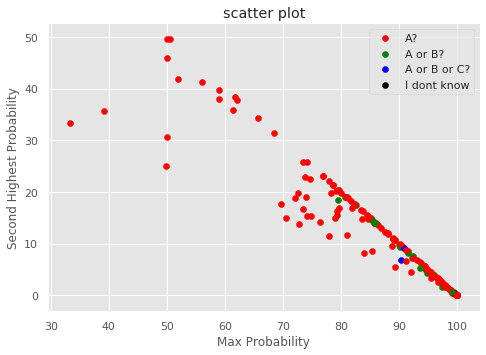

{(85, 5): {(('IDENTIFY',),): 2,
  (("('COMPARE_REF', '[or]')", 'IDENTIFY', 'IDENTIFY'),): 1},
 (70, 25): {(("('COMPARE_REF', '[or]')", 'IDENTIFY', 'IDENTIFY'),): 1,
  (('IDENTIFY',),): 1},
 (70, 15): {(("('COMPARE_REF', '[or]')", 'IDENTIFY', 'IDENTIFY'),): 3,
  (('IDENTIFY',),): 4},
 (80, 15): {(("('COMPARE_REF', '[or]')", 'IDENTIFY', 'IDENTIFY'),): 9,
  (("('COMPARE_REF', '[or]')",
    'IDENTIFY',
    'IDENTIFY_FROM_REF',
    'IDENTIFY',
    'IDENTIFY'),): 1,
  (("('COMPARE_REF', '[')",
    'IDENTIFY',
    "('COMPARE_REF', '[')",
    'IDENTIFY',
    'IDENTIFY'),): 1,
  (("('COMPARE_REF', '[')",
    'IDENTIFY',
    "('COMPARE_REF', '[or]')",
    'IDENTIFY',
    'IDENTIFY'),): 1,
  (('IDENTIFY',),): 2,
  (('DISTINGUISH', 'IDENTIFY'),): 1,
  (('IDENTIFY_FROM_REF', 'IDENTIFY', 'IDENTIFY'),): 1},
 (85, 10): {(('DISTINGUISH', 'IDENTIFY'),): 1,
  (('IDENTIFY',),): 7,
  (('IDENTIFY_FROM_REF', 'IDENTIFY', 'DISTINGUISH', 'IDENTIFY'),): 1,
  (("('COMPARE_REF', '[or]')", 'IDENTIFY', 'IDENTIFY'),)

In [17]:
##Clarifications to Speaker Response
distribution_response_map
bucket_response = dict()

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
clr_map = {0 : 'k', 1 : 'r', 2 : 'g', 3 : 'b'}
flag = {0 : False, 1 : False, 2 : False, 3 : False}
labels = {0 : 'I dont know', 1 : 'A?', 2 : 'A or B?', 3 : 'A or B or C?'}
for k, v in distribution_response_map.items():
    probs = np.array(k)
    probs.sort()
    max_dist = probs[2]
    bucket_prob = int(max_dist*100) - (int(max_dist * 100) % 5)
    max2_dist = probs[1]
    bucket_prob2 = int(max2_dist * 100) - (int(max2_dist * 100) % 5)
    bucket_response.setdefault((bucket_prob, bucket_prob2), dict())
    bucket_response[(bucket_prob, bucket_prob2)].setdefault(tuple(v), 0)
    bucket_response[(bucket_prob, bucket_prob2)][tuple(v)] += 1
    
    for strat in v:
        count = 0
        conj_flag = False
        for const in strat:
            if 'IDENTIFY' == const:
                count += 1
        for const in strat:
            if const == 'COMPARE_REF':
                conj_flag = True
        if not conj_flag and count > 1:
            count -= 1
        if count > 3:
            count = 3
        
        if not flag[count]:
            ax.scatter(max_dist * 100, max2_dist * 100, color=clr_map[count], label=labels[count])
            flag[count] = True
        else:
            ax.scatter(max_dist * 100, max2_dist * 100, color=clr_map[count])
            
ax.set_xlabel('Max Probability')
ax.set_ylabel('Second Highest Probability')
ax.set_title('scatter plot')
plt.legend()
plt.show()
bucket_response